In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(torch.__version__)

1.5.1


## GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


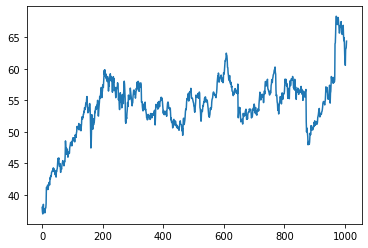

In [3]:
data = pd.read_csv('starbucks.csv')

data['Close'].plot()
plt.show()

## train, validation

In [4]:
train = data['Close'][:800].reset_index(drop=True)
valid = data['Close'][800:].reset_index(drop=True)

## Make dataset

In [5]:
class WindowedDataset(Dataset):
    
    def __init__(self, series, windowSize):
        self.X = []
        self.y = []
        for idx in range(0,len(series) - windowSize):
            self.X = np.append(self.X, series[idx:idx+windowSize])
            self.y = np.append(self.y, series[idx+windowSize])
        self.X = self.X.reshape(-1, windowSize)
        self.y = self.y.reshape(-1,1)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.Tensor(self.X[idx])
        y = torch.Tensor(self.y[idx])
        return X, y

In [121]:
seqLen = 12
batchSize = 4
dataDim = 1

windowedDataset = WindowedDataset(train, windowSize=seqLen)
loader = DataLoader(windowedDataset, batch_size=batchSize, 
                    shuffle=True, drop_last=True)

In [122]:
dataiter = iter(loader)
data = dataiter.next()

features, labels = data
print(features.shape, labels.shape)

torch.Size([4, 12]) torch.Size([4, 1])


In [123]:
print(features.shape)
print(labels.shape)

torch.Size([4, 12])
torch.Size([4, 1])


In [124]:
features.view(batchSize, -1, 1).shape

torch.Size([4, 12, 1])

## Make model

In [125]:
class LSTM(nn.Module):
    def __init__(self, inputDim, hiddenDim, numLayers, outputDim, batchSize):
        super(LSTM, self).__init__()
        
        self.inputDim = inputDim
        self.hiddenDim = hiddenDim
        self.numLayers = numLayers
        self.outputDim = outputDim
        self.batchSize = batchSize
        
        self.lstm = nn.LSTM(inputDim, hiddenDim, numLayers, batch_first=True)
        self.fc = nn.Linear(hiddenDim, outputDim)
            
    def forward(self, x):
        # set initial states
        #h0 = torch.zeros(self.numLayers*2, self.batchSize, self.hiddenDim).to(device)
        #c0 = torch.zeros(self.numLayers*2, self.batchSize, self.hiddenDim).to(device)
        # forward
        out, _ = self.lstm(x.view(self.batchSize, -1, self.inputDim))
        # decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        return out

In [126]:
model = LSTM(inputDim=dataDim, hiddenDim=64, outputDim=1, 
               numLayers=2, batchSize=batchSize).to(device)

In [127]:
model

BiLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [128]:
criterion = nn.SmoothL1Loss() # Hubor loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

## Train

In [129]:
numEpochs = 150
nTotalStep = len(loader)

for epoch in tqdm_notebook(range(numEpochs)):
    for idx, (feature, target) in enumerate(loader):
        feature = feature.to(device)
        target = target.to(device)
        
        yPred = model(feature)
        loss = criterion(yPred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        print(f'epoch : {epoch+1} / {numEpochs},loss : {loss.item()}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


epoch : 10 / 150,loss : 2.2735610008239746
epoch : 20 / 150,loss : 0.9552121162414551
epoch : 30 / 150,loss : 0.14829789102077484
epoch : 40 / 150,loss : 0.3368063271045685
epoch : 50 / 150,loss : 0.519007682800293
epoch : 60 / 150,loss : 0.4326764643192291
epoch : 70 / 150,loss : 0.14846543967723846
epoch : 80 / 150,loss : 0.15253566205501556
epoch : 90 / 150,loss : 0.39117687940597534
epoch : 100 / 150,loss : 0.02900160476565361
epoch : 110 / 150,loss : 0.013330632820725441
epoch : 120 / 150,loss : 0.17240914702415466
epoch : 130 / 150,loss : 0.028875702992081642
epoch : 140 / 150,loss : 0.2720140516757965
epoch : 150 / 150,loss : 0.16406697034835815



## train set predict

In [134]:
trainForecast = []
with torch.no_grad():
        for idx, (feature, target) in enumerate(loader):
            feature = feature.to(device)
            target = target.to(device)
            
            output = model(feature).to('cpu')
            trainForecast = np.append(trainForecast, output)

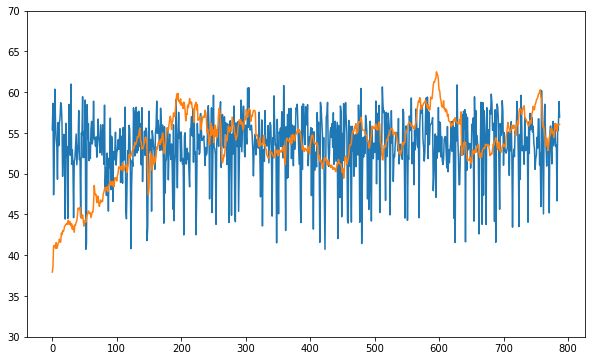

In [148]:
plt.figure(figsize=(10, 6))

plt.ylim(30,70)
plt.plot(trainForecast)
plt.plot(train[12:].reset_index(drop=True))

## validation set predict

In [136]:
windowedDatasetValid = WindowedDataset(valid, windowSize=seqLen)
loaderValid = DataLoader(windowedDatasetValid, batch_size=batchSize, shuffle=True)
forecast = []
with torch.no_grad():
        for idx, (feature, target) in enumerate(loaderValid):
            feature = feature.to(device)
            
            target = target.to(device)
            
            output = model(feature).to('cpu')
            forecast = np.append(forecast, output)

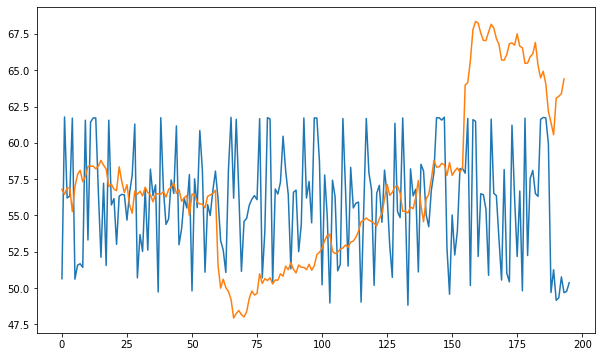

In [147]:
plt.figure(figsize=(10, 6))

plt.plot(forecast)
plt.plot(valid[12:].reset_index(drop=True))

## WTF!!